# Second order inchworm configuration and its contribution to the pseudo-particle self-energy

In [1]:
import Keldysh; kd = Keldysh
import KeldyshED; ked = KeldyshED; op = KeldyshED.Operators;

import QInchworm.ppgf

import QInchworm; cfg = QInchworm.configuration

import QInchworm.configuration: Expansion, InteractionPair
import QInchworm.configuration: Configuration, Node, InchNode, NodePair, NodePairs

import QInchworm.qmc_integrate: qmc_time_ordered_integral, qmc_time_ordered_integral_n_samples

import Sobol: SobolSeq
import LinearAlgebra: norm

include("DelaunaySimplex.jl")

┌ Info: Precompiling QInchworm [c1b6c5a0-2f71-4f50-a75d-692762eff855]
└ @ Base loading.jl:1423
┌ Warning: Package QInchworm does not have Test in its dependencies:
│ - If you have QInchworm checked out for development and have
│   added Test as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with QInchworm
└ Loading Test into QInchworm from project dependency, future warnings for QInchworm are suppressed.


Main.DelaunaySimplex

## Single correlated atom coupled to a bath level

System parameters

In [2]:
β = 10.;         # Inverse temperature
U = 1.0;         # Coulomb interaction
μ = U/2 + 0.3;   # Chemical potential
B = 0.1;         # Magnetic field
#ϵ = [-0.1, +0.1] # Bath energy levels
ϵ = [-1.0, +1.0] # Bath energy levels
V = 1.0;         # Hopping

Discretization

In [3]:
nt = 2;
ntau = 3;
#ntau = 1001;
#ntau = 5001;
tmax = 1.0;

Exact Diagonalization

In [4]:
H = -μ * (op.n(0, "up") + op.n(0, "dn")) + U * op.n(0, "up") * op.n(0, "dn") + B * (op.n(0, "up") - op.n(0, "dn"));
soi = ked.Hilbert.SetOfIndices([[0, "up"], [0, "dn"]]);
ed = ked.EDCore(H, soi);
ρ = ked.density_matrix(ed, β);

3-branch time contour

In [5]:
contour = kd.twist(kd.FullContour(tmax=tmax, β=β));
grid = kd.FullTimeGrid(contour, nt, ntau);

Hybridization function

In [6]:
dos = kd.DeltaDOS(ϵ, V^2 * ones(length(ϵ)))
Δ = kd.FullTimeGF(dos, grid);

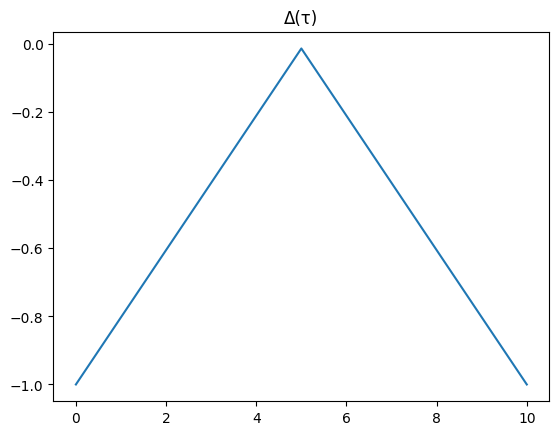

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/igor/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [7]:
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

tau = Array(LinRange(0, β, 101))

b = contour[kd.imaginary_branch]
t0 = b(tau[1])
times = [ b(t/β) for t in tau ]
vals = [ Δ(t, t0) for t in times ]

plt.title("Δ(τ)")
plt.plot(tau, imag.(vals), "-");

Pseudo Particle Strong Coupling Expansion

In [8]:
ip_up = InteractionPair(op.c_dag(0, "up"), op.c(0, "up"), Δ);
ip_dn = InteractionPair(op.c_dag(0, "dn"), op.c(0, "dn"), Δ);
ppsc_exp = Expansion(ed, grid, [ip_up, ip_dn]);

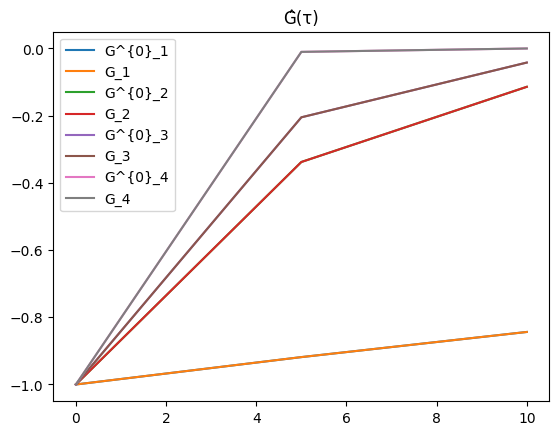

In [9]:
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

plt.title("Ĝ(τ)")
for (idx, G_s) in enumerate(ppsc_exp.P0)
    vals = [ G_s(t, t0) for t in times ]
    vals = vcat(vals...)    
    plt.plot(tau, imag.(vals), "-", label="G^{0}_$idx")

    vals = [ ppsc_exp.P[idx](t, t0) for t in times ]
    vals = vcat(vals...)    
    plt.plot(tau, imag.(vals), "-", label="G_$idx")
end

plt.legend(loc="best");

2nd order inchworm diagram on the imaginary branch

In [10]:
tau_grid = grid[kd.imaginary_branch]
τ_0, τ_β = tau_grid[1], tau_grid[end]

for t in tau_grid
    println(imag(t.bpoint.val))
end

τ_i = τ_0
τ_f = τ_β

τ_w_pos = 0.5 # Inchworm split time at 0.8β
#τ_w_pos = 0.8 # Inchworm split time at 0.8β
τ_w_idx = 1 + Int(τ_w_pos * (ntau - 1))
τ_w = tau_grid[τ_w_idx]
println(τ_w)

n_i = Node(τ_i.bpoint)
n_w = InchNode(τ_w.bpoint)
n_f = Node(τ_f.bpoint)

nodes = [n_f, n_w, n_i]
conf_0 = Configuration(nodes, NodePairs());
init_0 = zero(cfg.eval(ppsc_exp, conf_0));

0.0
-5.0
-10.0
Keldysh.TimeGridPoint(4, 2, Keldysh.BranchPoint(0.0 - 5.0im, 0.5, Keldysh.imaginary_branch))


Quasi Monte Carlo integration over a $d = 3$ domain

In [11]:
function second_order_diag_eval(τ)
    # Loop over spin indices of hybridization lines
    sum = deepcopy(init_0)
    for index1 = 1:2, index2 = 1:2
        # 4 arrangements of creation and annihilation operators
        conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
        sum += cfg.eval(ppsc_exp, conf)
        conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
        sum += cfg.eval(ppsc_exp, conf)
    end
    return sum
end

second_order_diag_eval (generic function with 1 method)

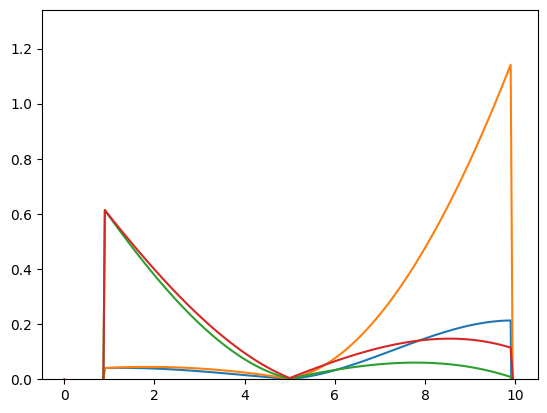

t1 = Keldysh.BranchPoint(0.0 - 0.8999999999999999im, 0.09, Keldysh.imaginary_branch)


(0.0, 1.341013183312797)

In [12]:
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

t1 = b(tau[10]/β)
println("t1 = $t1")

vals = [ second_order_diag_eval([b(t/β), t1, t0]) for t in tau ]
#println(vals)

for s in 1:4
    val_s = [ d[s][2] for d in vals ]
    val_s = vcat(val_s...)    
    #println(val_s)
    plt.plot(tau, imag.(val_s))
end

plt.ylim(bottom=0)

In [13]:
import MultiQuad: tplquad

func_sector(z, y, x, sector) = -imag(second_order_diag_eval([b(z/β), b(y/β), b(x/β)])[sector][2][1, 1])

tau_w = τ_w_pos*β

quad_res = [ tplquad((z,y,x) -> func_sector(z, y, x, s), 
        0, tau_w, x->x, x->tau_w, (x,y)->y, (x,y)->tau_w, rtol=1e-3, atol=1e-3) for s in 1:4]

error = [ s[2] for s in quad_res ]
integral = [ s[1] for s in quad_res ]

println("error = $error")
println("integral = $integral")

error = [0.0006290578851673931, 0.0008217614658239947, 0.0024954267168174164, 0.0025626969506611086]
integral = [-0.5420857649497705, -0.5420982242697353, -3.389633774645594, -3.3895344178050255]


# Delaunay triangulation and integration

In [14]:
tau_vals = [-imag(t.bpoint.val) for t in tau_grid]
points, simplices = DelaunaySimplex.triangulate(tau_vals[1:τ_w_idx], 3);

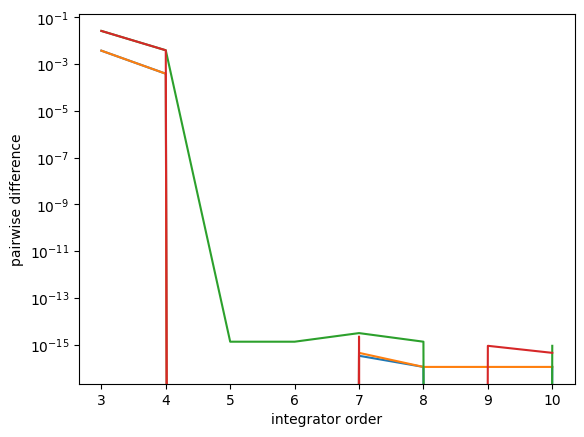

integral = [-0.5420857649497705, -0.5420982242697353, -3.389633774645594, -3.3895344178050255]
val(2)    = [-0.5382700597800326, -0.5382700597800325, -3.4161458890803815, -3.416145889080382]
val(3)    = [-0.5416643736349807, -0.5416643736349807, -3.393611669117836, -3.393611669117836]
diff      = [-0.003394313854948039, -0.00339431385494815, 0.022534219962545343, 0.022534219962545787]
val(4)    = [-0.5420546393194652, -0.5420546393194652, -3.3896804880899754, -3.389680488089975]
diff      = [-0.00039026568448452537, -0.00039026568448452537, 0.003931181027860831, 0.003931181027861275]
val(5)    = [-0.5420546393194652, -0.5420546393194652, -3.3896804880899754, -3.389680488089975]
diff      = [0.0, 0.0, 0.0, 0.0]
val(6)    = [-0.5420546393194655, -0.5420546393194656, -3.389680488089977, -3.389680488089977]
diff      = [-3.3306690738754696e-16, -4.440892098500626e-16, -1.7763568394002505e-15, -2.220446049250313e-15]
val(7)    = [-0.5420546393194653, -0.5420546393194653, -3.3896804880899754

In [15]:
println("integral = $integral")

scalar_integrand(x, sector) = func_sector(x[1], x[2], x[3], sector)

orders = collect(2:1:10)
res = Array{Float64, 2}(undef, 0, 4)
for order = orders
    val = [
        DelaunaySimplex.integrate_t3(points, simplices, order) do x
            [scalar_integrand(x[:, i], sector) for i = 1:size(x, 2)]
        end
        for sector = 1:4
    ]
    println("val($order)    = $val")
    if length(res) > 0
        diff = val - res[end, :]
        println("diff      = $diff")
    end
    res = cat(res, val'; dims=1)
end

errors = abs.(res[1:end-1, :] .- res[end, :]')
@show errors

plt.semilogy(orders[2:end], errors)
plt.xlabel("integrator order")
plt.ylabel("pairwise difference")
plt.savefig("figure_delaunay_integration_convergence.pdf")

## Numerical experiments

In [16]:
function do_2nd_order_inchworm_diagram(τ_qmc, seq; N = nothing, N_samples = nothing)
    integrand = τ -> begin
        # Loop over spin indices of hybridization lines
        sum = deepcopy(init_0)
        for index1 = 1:2, index2 = 1:2
            # 4 arrangements of creation and annihilation operators
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
        end
        sum
    end
    
    if !isnothing(N)
        return qmc_time_ordered_integral(integrand, 3, contour,
                                         τ_i.bpoint, τ_w.bpoint,
                                         init = deepcopy(init_0),
                                         seq = seq, τ = τ_qmc, N = N)
    end
    if !isnothing(N_samples)
        return qmc_time_ordered_integral_n_samples(integrand, 3, contour,
                                                   τ_i.bpoint, τ_w.bpoint,
                                                   init = deepcopy(init_0),
                                                   seq = seq, τ = τ_qmc, N_samples = N_samples)
    end
    throw(ArgumentError("Either N or N_samples must be specified"))
end

do_2nd_order_inchworm_diagram (generic function with 1 method)

In [17]:
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

# Scan a range of qRNG point numbers N using incremental evaluation of the integral
function scan_N_range(τ_qmc, N_step::Int, N_points::Int)
    println("τ_qmc = $τ_qmc")
    N_list = zeros(Int, N_points)
    chunks = zeros(Complex{Float64}, 4, N_points)
    Threads.@threads for i = 1:N_points
        N = i * N_step
        N_list[i] = N
        
        seq = SobolSeq(3)
        seq = skip(seq, N_step * N_points) # Acclaimed better uniformity see Sobol.jl docs
        seq = skip(seq, N - N_step, exact=true)
        
        val, N_samples = do_2nd_order_inchworm_diagram(τ_qmc, seq, N = N_step)
        chunks[:, i] = [val[s][2][1] for s = 1:4]
        
        println("N = $N, N_samples = $N_samples, val = ", chunks[:, i])
        flush(stdout)
    end
    results = cumsum(chunks, dims=2)
    for i = 1:N_points
        results[:, i] /= i
    end
    (N_list, results)
end

# Scan a range of sample numbers N_samples using incremental evaluation of the integral
function scan_N_samples_range(τ_qmc, N_samples_step::Int, N_samples_points::Int)
    println("τ_qmc = $τ_qmc")
    N_samples_list = zeros(Int, N_samples_points)
    chunks = zeros(Complex{Float64}, 4, N_samples_points)
    
    N_total = 0
    for i = 1:N_samples_points
        N_samples = N_samples_step * i
        N_samples_list[i] = N_samples
        
        seq = SobolSeq(3)
        seq = skip(seq, N_samples_step * N_samples_points) # Acclaimed better uniformity see Sobol.jl docs
        if N_total > 0
            seq = skip(seq, N_total, exact=true)
        end
        
        val, N = do_2nd_order_inchworm_diagram(τ_qmc, seq, N_samples = N_samples_step)
        chunks[:, i] = [val[s][2][1] for s=1:4]
        N_total += N
        
        println("N = $N, N_samples = $N_samples, val = ", chunks[:, i])
        flush(stdout)
    end
    results = cumsum(chunks, dims=2)
    for i = 1:N_samples_points
        results[:, i] /= i
    end
    (N_samples_list, results)
end

# Scan a range of qRNG point numbers N without optimizations
function scan_N_range_unopt(τ_qmc, N_step::Int, N_points::Int)
    println("τ_qmc = $τ_qmc")
    N_list = collect(range(N_step, step=N_step, length=N_points))
    results = zeros(Complex{Float64}, 4, N_points)
    Threads.@threads for (i, N) in collect(enumerate(N_list))
        N_list[i] = N
        
        val, N_samples = do_2nd_order_inchworm_diagram(τ_qmc, SobolSeq(3), N = N_step)
        
        results[:, i] = [val[s][2][1] for s=1:4]
        println("N = $N, N_samples = $N_samples, res = ", results[:, i])
        flush(stdout)
    end
    (N_list, results)
end

using HDF5
function h5_write_results(group_name, ref, τ_qmc, N_range, results, div)
    h5open("2nd_order_inchworm.h5", "cw") do file
        if group_name in keys(file)
            delete_object(file, group_name)
        end
        g = create_group(file, group_name)
        write(g, "ref", ref)
        write(g, "tau_qmc", τ_qmc)
        write(g, "N_range", collect(N_range))
        write(g, "results", results)
        write(g, "div", div)
    end
end

h5_write_results (generic function with 1 method)

In [18]:
Threads.nthreads()

10

In [19]:
#τ_qmc = 4.0β
#τ_qmc = 2.0β
τ_qmc = 1.0β
#τ_qmc = 0.5β

#N_step = 100000
#N_points = 80 * 100

N_step = 10000
N_points = 24 * 100

@time N_list, results = scan_N_range(τ_qmc, N_step, N_points);

## Check against the unoptimized version
#N_list_unopt, results_unopt = scan_N_range_unopt(τ_qmc, N_step, N_points)
#@assert N_list == N_list_unopt
#@assert isapprox(norm(results - results_unopt, Inf), 0, atol=1e-14)

results[:, end]

τ_qmc = 10.0
N = 19210000, N_samples = 139, val = ComplexF64[-0.5287275080409681 + 0.0im, -0.5327761712962381 + 0.0im, -3.208412361031854 + 0.0im, -3.2221030943231 + 0.0im]
N = 10000, N_samples = 153, val = ComplexF64[-0.5896658589292092 + 0.0im, -0.5949123470863169 + 0.0im, -3.8397391697734755 + 0.0im, -3.8525935908622424 + 0.0im]
N = 16810000, N_samples = 145, val = ComplexF64[-0.5495105263749264 + 0.0im, -0.5516000862976216 + 0.0im, -3.5521789863608406 + 0.0im, -3.55998004119782 + 0.0im]
N = 4810000, N_samples = 148, val = ComplexF64[-0.5701479136959281 + 0.0im, -0.5781581393328524 + 0.0im, -3.6704308278600735 + 0.0im, -3.6887358971354263 + 0.0im]
N = 9610000, N_samples = 148, val = ComplexF64[-0.561227334937278 + 0.0im, -0.5706626669748726 + 0.0im, -3.5725525458083554 + 0.0im, -3.598565565945128 + 0.0im]
N = 21610000, N_samples = 144, val = ComplexF64[-0.5269813629165633 + 0.0im, -0.5202817871835703 + 0.0im, -3.2402803969173877 + 0.0im, -3.2208511557956103 + 0.0im]
N = 2410000, N_s

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
     [1] [0m[1mArray[22m
    [90m   @ [39m[90m./[39m[90m[4mboot.jl:457[24m[39m[90m [inlined][39m
     [2] [0m[1m#skip#2[22m
    [90m   @ [39m[90m~/.julia/packages/Sobol/5NmUh/src/[39m[90m[4mSobol.jl:98[24m[39m[90m [inlined][39m
     [3] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m./[39m[90m[4mIn[17]:14[24m[39m[90m [inlined][39m
     [4] [0m[1m(::var"#62#threadsfor_fun#31"{Float64, Int64, Int64, Matrix{ComplexF64}, Vector{Int64}, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:85[24m[39m
     [5] [0m[1m(::var"#62#threadsfor_fun#31"{Float64, Int64, Int64, Matrix{ComplexF64}, Vector{Int64}, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:52[24m[39m

N = 2460000, N_samples = 140, val = 

In [20]:
ref = val
println("res = $(real(results[:, end]))")
println("ref = $ref")
println("diff = $(abs.(real(results[:, end]) - ref))")

div = results - (ref .* ones(Float64, N_points)')

h5_write_results("tau_qmc_$τ_qmc", ref, τ_qmc, N_list, results, div)

for s=1:4
    plt.loglog(N_list, abs.(div[s, :]), label = "\$s=$s\$")
end

for i = -3:5
    plt.loglog(N_list, 10. .^i ./N_list, "-k", lw=0.5)
    plt.loglog(N_list, 10. .^(i-2) ./ sqrt.(N_list), ":k", lw=0.5)
end

plt.xlabel(raw"$N$")
plt.ylabel(raw"$|P - P_{ref}|$")
plt.xlim(N_list[1], N_list[end])
plt.ylim(minimum(abs.(div)), maximum(abs.(div)))
plt.legend(title="\$\\tau_{qmc} = $τ_qmc\$")

#plt.text(1e5, 1e-7, "\$\\tau_{qmc} = $τ_qmc\$")

plt.savefig("2nd_order_inchworm_tau$τ_qmc.pdf")

ComplexF64[

LoadError: UndefVarError: val not defined

-0.5205813364605433 + 0.0im,

In [21]:
#τ_qmc = 4.0β
#τ_qmc = 2.0β
τ_qmc = 1.0β
#τ_qmc = 0.5β

#N_step = 100000
#N_points = 80 * 100

N_samples_step = 1000
N_samples_points = 24 * 100

@time N_samples_list, results = scan_N_samples_range(τ_qmc, N_samples_step, N_samples_points);

@show N_samples_list
@show results[:, end]

 -0.512484698597539 + 0.0im, -3.185744547262251 + 0.0im, -3.1632245212382735 + 0.0im]
N = 7260000, N_samples = 140, val = ComplexF64[-0.524233090601773 + 0.0im, -0.5177126956900452 + 0.0im, -3.251143135732111 + 0.0im, -3.2358383042088654 + 0.0im]
N = 4860000, N_samples = 137, val = ComplexF64[-0.5290647668137455 + 0.0im, -0.5209861897975969 + 0.0im, -3.301187577551052 + 0.0im, -3.2790543088925164 + 0.0im]
N = 9660000, N_samples = 139, val = ComplexF64[-0.5238713459204304 + 0.0im, -0.516388784712954 + 0.0im, -3.2065307787738053 + 0.0im, -3.18690685281671 + 0.0im]
N = 12060000, N_samples = 144, val = ComplexF64[-0.552416724325474 + 0.0im, -0.551487321028263 + 0.0im, -3.5554610622430696 + 0.0im, -3.5525361571632477 + 0.0im]
N = 21660000, N_samples = 142, val = ComplexF64[-0.5444415346980059 + 0.0im, -0.5423599486525074 + 0.0im, -3.4122894313935874 + 0.0im, -3.408162895460965 + 0.0im]
τ_qmc = 10.0
N = 14460000, N_samples = 142, val = 

LoadError: InterruptException:

ComplexF64

In [22]:
ref = val
println("res = $(real(results[:, end]))")
println("ref = $ref")
println("diff = $(abs.(real(results[:, end]) - ref))")

div = results - (ref .* ones(Float64, N_samples_points)')

h5_write_results("tau_qmc_n_sampled_$τ_qmc", ref, τ_qmc, N_samples_list, results, div)

for s=1:4
    plt.loglog(N_samples_list, abs.(div[s, :]), label = "\$s=$s\$")
end

for i = -3:5
    plt.loglog(N_samples_list, 10. .^i ./N_samples_list, "-k", lw=0.5)
    plt.loglog(N_samples_list, 10. .^(i-2) ./ sqrt.(N_samples_list), ":k", lw=0.5)
end

plt.xlabel(raw"$N$")
plt.ylabel(raw"$|P - P_{ref}|$")
plt.xlim(N_samples_list[1], N_samples_list[end])
plt.ylim(minimum(abs.(div)), maximum(abs.(div)))
plt.legend(title="\$\\tau_{qmc} = $τ_qmc\$")

#plt.text(1e5, 1e-7, "\$\\tau_{qmc} = $τ_qmc\$")

plt.savefig("2nd_order_inchworm_n_samples_tau$τ_qmc.pdf")

[

LoadError: UndefVarError: val not defined

-0.5278693556908406 + 0.0

In [23]:
# Test a single value of the integrand

τ = [tau_grid[end-20].bpoint, tau_grid[end-30].bpoint, tau_grid[end-40].bpoint]
@show τ

@show Δ(n_f.time, τ[2])
@show Δ(τ[2], n_f.time)
@show Δ(τ[1], τ[3])
@show Δ(τ[3], τ[1])

s = deepcopy(init_0)   
for index1 = 1:2, index2 = 1:2
    # 4 arrangements of creation and annihilation operators
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
    @show v1 = cfg.eval(ppsc_exp, conf)
    s += v1
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
    @show v2 = cfg.eval(ppsc_exp, conf)
    s += v2
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
    @show v3 = cfg.eval(ppsc_exp, conf)
    s += v3
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
    @show v4 = cfg.eval(ppsc_exp, conf)
    s += v4
end
    
println(s)

im, -0.5271980349703574 + 

LoadError: SYSTEM: show(lasterr) caused an error

0.0im, -3.256446729060322 + 0.0im, -3.2574714751894107 + 0.0im]
N = 2470000, N_samples = 138, val = ComplexF64[-0.5117008470124748 + 0.0im, -0.5042408462117475 + 0.0im, -3.146822368734492 + 0.0im, -3.1264799333002213 + 0.0im]
N = 19260000, N_samples = 147, val = ComplexF64[-0.5428286534691793 + 0.0im, -0.5434611278179811 + 0.0im, -3.364058649202435 + 0.0im, -3.3654380015584744 + 0.0im]
N = 16860000, N_samples = 149, val = ComplexF64[-0.5454606440903026 + 0.0im, -0.5471972407281835 + 0.0im, -3.4607690486367675 + 0.0im, -3.4647960363465558 + 0.0im]
N = 4870000, N_samples = 147, val = ComplexF64[-0.5516045615928247 + 0.0im, -0.5522576654850394 + 0.0im, -3.4706082538020446 + 0.0im, -3.467231191380052 + 0.0im]
N = 12070000, N_samples = 148, val = ComplexF64[-0.5643476482991611 + 0.0im, -0.564892846451014 + 0.0im, -3.6394848310195296 + 0.0im, -3.642296491872589 + 0.0im]
N = 7270000, N_samples = 148, val = ComplexF64[-0.5692268665671064 + 0.0im, -0.5753511144546518 + 0.0im, -3.648590139010137